# Harris Corner Feature Tracking Algorithm

In [ ]:
import cv2
import numpy as np
import time
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
img1 = cv2.imread('assignment4-pictures/DSC_0554.JPG')
img2 = cv2.imread('assignment4-pictures/DSC_0555.JPG')
img3 = cv2.imread('assignment4-pictures/DSC_0556.JPG')
img4 = cv2.imread('assignment4-pictures/DSC_0557.JPG')

img1_g = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2_g = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
img3_g = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY)
img4_g = cv2.cvtColor(img4, cv2.COLOR_RGB2GRAY)

In [3]:
def image_split(img, window_w, window_h):
    partition_list = []
    for i in range(0, img.shape[1], window_w):
        for j in range(0, img.shape[0], window_w):
            img_temp = img[i:i + window_h, j:j + window_w]
            partition_list.append(img_temp)
    return partition_list

In [4]:
def LK_create_pyramid(img_1, img_2, window):
    shape = np.shape(img_1)
    levels = 3
    new_A = []
    top_1_1 = reduce(img_1, levels)
    top_2_1 = reduce(img_2, levels)
    top_1_2 = reduce(img_1, levels -1)
    top_2_2 = reduce(img_2, levels -1)
    u, v = LK_optical_flow(top_1_1, top_2_1, window)
    flow = 2 * (np.dstack((u,v)))
    flow = cv2.resize(flow,(top_1_2.shape[1], top_2_2.shape[0]))
    new_A = LK_warping(np.float32(top_2_2), np.float32(flow))
    print('first', top_1_1.shape)
    
    top_1_1 = reduce(img_1, levels -1)
    top_2_1 = reduce(img_2, levels -1)
    top_1_2 = reduce(img_1, levels -2)
    top_2_2 = reduce(img_2, levels -2)
    u, v = LK_optical_flow(top_1_1, top_2_1, window)
    flow = 2 * (np.dstack((u,v)))
    flow = cv2.resize(flow,(top_1_2.shape[1], top_2_2.shape[0]))
    new_A = LK_warping(np.float32(top_2_2), np.float32(flow))
    print('second', top_1_1.shape)
    
    top_1_1 = reduce(img_1, levels -2)
    top_2_1 = reduce(img_2, levels -2)
    top_1_2 = reduce(img_1, levels -3)
    top_2_2 = reduce(img_2, levels -3)
    u, v = LK_optical_flow(top_1_1, top_2_1, window)
    flow = np.dstack((u,v)).astype("float32")
    print('final', top_1_1.shape)
    flow_final = cv2.resize(flow, (img1.shape[0],img1.shape[1]))
    return flow_final

In [5]:
def LK_warping(img1, flow):
    h, w = flow.shape[:2]
    flow = -2 * flow
    flow[:,:,0] += np.arange(w) ##u
    flow[:,:,1] += np.arange(h)[:,np.newaxis] ##v
    mask = cv2.remap(img1, flow, None, cv2.INTER_LINEAR)
    return mask

In [6]:
def LK_optical_flow(img_1, img_2, window_size,t=0.1):
 
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])
    w = int(window_size/2)
    img_1 = img_1 / 255.
    img_2 = img_2 / 255.
    shape = np.shape(img_1)
    fx = signal.convolve2d(img_1, kernel_x, boundary='symm', mode='same')
    fy = signal.convolve2d(img_1, kernel_y, boundary='symm', mode='same')
    ft = signal.convolve2d(img_2, kernel_t, boundary='symm', mode='same') - signal.convolve2d(img_1, kernel_t, boundary='symm', mode='same')
    u = np.zeros(img_1.shape)
    v = np.zeros(img_1.shape)

    for i in range(w, img_1.shape[0]-w):
        for j in range(w, img_1.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            A=np.array([Ix, Iy]).T
            A_ = np.dot(A.T, A)
            A_inv = np.linalg.pinv(A_)
            b=np.array([It]).T
            b_ = np.dot(A.T, b)
            
            if np.linalg.matrix_rank(np.dot(A.T, A)) == 2:
                nu = np.dot(A_inv, b_)
                u[i,j]=nu[0]
                v[i,j]=nu[1]
            else:
                u[i,j]=0
                v[i,j]=0
                
    return u,v

In [7]:
def reduce(image, levels):
    result = np.copy(image)
    for i in range(levels-1):
        result = cv2.pyrDown(result)
    return result
     
def expand(image):
    return cv2.pyrUp(np.copy(image))

In [8]:
def HC_detectection(img_gray, img, max_corners, mini_dist):
    corners = cv2.goodFeaturesToTrack(img_gray,maxCorners = max_corners, qualityLevel = 0.01,
                                  minDistance = mini_dist, blockSize = 10, useHarrisDetector = True).astype(int)
    for i in corners:
        x,y = i.ravel()
        cv2.circle(img,(x,y),1,(155,20,255),2)
   
    # plt.imshow(img)
    # plt.show()  
    return corners


def get_corners(corners_list):
    max_corners = 10
    window_w = 200
    window_h = 200
    new_corner = []
    for i in range(0,len(corners_list)):
        corner_temp = corners_list[i]
        for j in range(0, len(corner_temp)):
            if i == 0:
                x = corner_temp[j][0][0]
                y = corner_temp[j][0][1]
                new_corner.append([x,y])
            elif i == 1:
                x = corner_temp[j][0][0] + window_w
                y = corner_temp[j][0][1]
                new_corner.append([x,y])
            elif i == 2:
                x = corner_temp[j][0][0]
                y = corner_temp[j][0][1] + window_h
                new_corner.append([x,y])
            elif i == 3:
                x = corner_temp[j][0][0] + window_w
                y = corner_temp[j][0][1] + window_h
                new_corner.append([x,y])
    return new_corner

In [9]:
def get_new_corner(previous_corner, flow):
    new_corner = []
    previous_corner_x = [previous_corner[i][0] for i in range(0,len(previous_corner))]
    previous_corner_y = [previous_corner[i][1] for i in range(0,len(previous_corner))]
    for j in range(0, len(previous_corner)):
        x = previous_corner_x[j]
        y = previous_corner_y[j]
        flow_temp_x = flow[x,y][0]
        flow_temp_y = flow[x,y][1]
        x2 = round(x + flow_temp_x)
        y2 = round(y + flow_temp_y)
        new_corner.append([x2, y2])
    return new_corner

In [10]:
def HC_tracking_LK(img1, img2):
    img1 = cv2.resize(img1, (400,400))
    img1_g = cv2.resize(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), (400,400))
    img1_g_list = image_split(img1_g, 200,200)
    img1_g_t1 = img1_g_list[0]
    img1_list = image_split(img1, 200,200)
    img1_t1 = img1_list[0]
    
    img2 = cv2.resize(img2, (400,400))
    img2_g = cv2.resize(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), (400,400))
    
    final_flow = LK_create_pyramid(img1_g, img2_g, 10)
    
    corners_list = []

    for i in range(0,len(img1_g_list)):
        corners_temp = HC_detectection(img1_g_list[i], img1_list[i], max_corners = 10, mini_dist = 20)
        corners_list.append(corners_temp)



    corner1 = get_corners(corners_list)
    corner2 = get_new_corner(corner1, final_flow)
    
    for i in corner1:
        x = i[0]
        y = i[1]
        cv2.circle(img1,(x,y),1,(155,20,255),2)
    
    for i in corner2:
        x = i[0]
        y = i[1]
        cv2.circle(img2,(x,y),1,(155,20,255),2)
    plt.imshow(img1)
    plt.show()
    plt.imshow(img2)
    plt.show() 

first (100, 100)
second (200, 200)
final (400, 400)


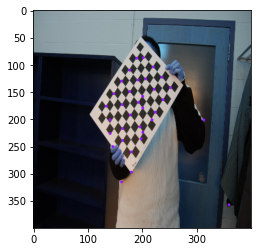

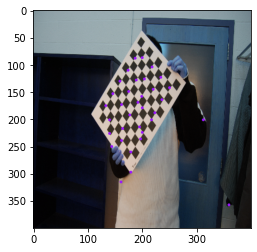

In [11]:
HC_tracking_LK(img1, img2)

first (100, 100)
second (200, 200)
final (400, 400)


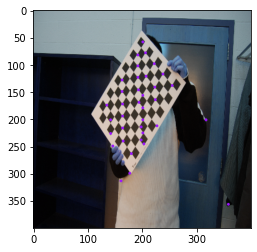

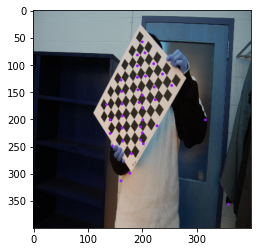

In [12]:
HC_tracking_LK(img2, img3)

first (100, 100)
second (200, 200)
final (400, 400)


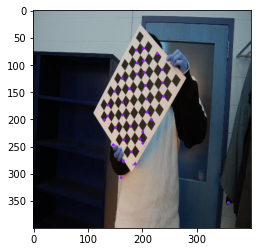

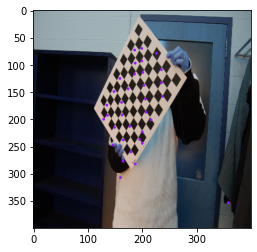

In [13]:
HC_tracking_LK(img3, img4)